#04. PyTorch Custom Datasets


Find a dataset, turn the dataset into numbers, build a model (or find an existing model) to find patterns in those numbers that can be used for prediction. PyTorch has many built-in datasets used for a wide number of machine learning benchmarks, however, you'll often want to use your own custom dataset.

##What is a custom dataset?
A custom dataset is a collection of data relating to a specific problem you're working on. In essence, a custom dataset can be comprised of almost anything. For example, if we were building a food image classification app like [Nutrify](https://nutrify.app/), our custom dataset might be images of food. Or if we were trying to build a model to classify whether or not a text-based review on a website was positive or negative, our custom dataset might be examples of existing customer reviews and their ratings.

Or if we were trying to build a sound classification app, our custom dataset might be sound samples alongside their sample labels.

Or if we were trying to build a recommendation system for customers purchasing things on our website, our custom dataset might be examples of products other people have bought.

PyTorch includes many existing functions to load in various custom datasets in the `TorchVision`, `TorchText`, `TorchAudio` and `TorchRec` domain libraries.
But sometimes these existing functions may not be enough. In that case, we can always subclass `torch.utils.data.Dataset` and customize it to our liking.

What we're going to cover in this notebook
We're going to be applying the PyTorch Workflow we covered in notebook 01 and notebook 02 to a computer vision problem. But instead of using an in-built PyTorch dataset, we're going to be using our own dataset of pizza, steak and sushi images. The goal will be to load these images and then build a model to train and predict on them.

What we're going to build. We'll use `torchvision.datasets` as well as our own custom Dataset class to load in images of food and then we'll build a PyTorch computer vision model to hopefully be able to classify them.


Specifically, we're going to cover:

**0. Importing PyTorch and setting up device-agnostic code**
Let's get PyTorch loaded and then follow best practice to setup our code to be device-agnostic.

**1. Get data**

We're going to be using our own custom dataset of pizza, steak and sushi images.

**2. Become one with the data (data preparation)**

At the beginning of any new machine learning problem, it's paramount to understand the data you're working with. Here we'll take some steps to figure out what data we have.

**3. Transforming data**

Often, the data you get won't be 100% ready to use with a machine learning model, here we'll look at some steps we can take to transform our images so they're ready to be used with a model.

**4. Loading data with ImageFolder (option 1)**

PyTorch has many in-built data loading functions for common types of data. ImageFolder is helpful if our images are in standard image classification format.

**5. Loading image data with a custom Dataset**

What if PyTorch didn't have an in-built function to load data with? This is where we can build our own custom subclass of torch.utils.data.Dataset.

**6. Other forms of transforms (data augmentation)**

Data augmentation is a common technique for expanding the diversity of your training data. Here we'll explore some of torchvision's in-built data augmentation functions.

**7. Model 0: TinyVGG without data augmentation**

By this stage, we'll have our data ready, let's build a model capable of fitting it. We'll also create some training and testing functions for training and evaluating our model.

**8. Exploring loss curves**

Loss curves are a great way to see how your model is training/improving over time. They're also a good way to see if your model is **underfitting** or **overfitting**.

**9. Model 1: TinyVGG with data augmentation**

By now, we've tried a model without, how about we try one with data augmentation?

**10. Compare model results**

Let's compare our different models' loss curves and see which performed better and discuss some options for improving performance.

**11. Making a prediction on a custom image**

Our model is trained to on a dataset of pizza, steak and sushi images. In this section we'll cover how to use our trained model to predict on an image outside of our existing dataset.

#0. Importing PyTorch and setting up device-agnostic code

In [2]:
import torch
from torch import nn

# Note: this notebook requires torch >= 1.10.0
torch.__version__

'2.5.1+cu124'

And now let's follow best practice and setup device-agnostic code.

In [3]:
# Setup device-agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

#1. Get data
Machine learning is an iterative process, start small, get something working and increase when necessary. The data we're going to be using is a subset of the [Food101 dataset](https://data.vision.ee.ethz.ch/cvl/datasets_extra/food-101/).

Food101 is popular computer vision benchmark as it contains 1000 images of 101 different kinds of foods, totaling 101,000 images (75,750 train and 25,250 test).

Instead of 101 food classes, we're going to start with 3: pizza, steak and sushi. And instead of 1,000 images per class, we're going to start with a random 10% (start small, increase when necessary).

If you'd like to see where the data came from you see the following resources:


*   Original [Food101 dataset and paper website.](https://data.vision.ee.ethz.ch/cvl/datasets_extra/food-101/)
*   `torchvision.datasets.Food101` - the version of the data we downloaded for this notebook.
*   `extras/04_custom_data_creation.ipynb` - a notebook we used to format the Food101 dataset to use for this notebook.
*   `data/pizza_steak_sushi.zip` - the zip archive of pizza, steak and sushi images from Food101, created with the notebook linked above.

Let's write some code to download the formatted data from GitHub.

Note: The dataset we're about to use has been pre-formatted for what we'd like to use it for. However, you'll often have to format your own datasets for whatever problem you're working on. This is a regular practice in the machine learning world.


In [4]:
import requests
import zipfile
from pathlib import Path

# Setup path to data folder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

# If the image folder doesn't exist, download it and prepare it...
if image_path.is_dir():
    print(f"{image_path} directory exists.")
else:
    print(f"Did not find {image_path} directory, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)

    # Download pizza, steak, sushi data
    with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
        request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
        print("Downloading pizza, steak, sushi data...")
        f.write(request.content)

    # Unzip pizza, steak, sushi data
    with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
        print("Unzipping pizza, steak, sushi data...")
        zip_ref.extractall(image_path)

Did not find data/pizza_steak_sushi directory, creating one...
Unzipping pizza, steak, sushi data...


#2. Data preparation
This is another important step before building a model.

Before starting a project or building any kind of model, it's important to know what data you're working with. In our case, we have images of pizza, steak and sushi in standard image classification format.

Image classification format contains separate classes of images in separate directories titled with a particular class name.

For example, all images of pizza are contained in the pizza/ directory.

This format is popular across many different image classification benchmarks, including [ImageNet](https://www.image-net.org/) (of the most popular computer vision benchmark datasets).

You can see an example of the storage format below, the images numbers are arbitrary.

pizza_steak_sushi/ <- overall dataset folder
    train/ <- training images
        pizza/ <- class name as folder name
            image01.jpeg
            image02.jpeg
            ...
        steak/
            image24.jpeg
            image25.jpeg
            ...
        sushi/
            image37.jpeg
            ...
    test/ <- testing images
        pizza/
            image101.jpeg
            image102.jpeg
            ...
        steak/
            image154.jpeg
            image155.jpeg
            ...
        sushi/
            image167.jpeg
            ...
The goal will be to take this data storage structure and turn it into a dataset usable with PyTorch.

Note: The structure of the data you work with will vary depending on the problem you're working on. But the premise still remains: become one with the data, then find a way to best turn it into a dataset compatible with PyTorch.

We can inspect what's in our data directory by writing a small helper function to walk through each of the subdirectories and count the files present.

To do so, we'll use Python's in-built `os.walk()`.


In [5]:
import os
def walk_through_dir(dir_path):
  """
  Walks through dir_path returning its contents.
  Args:
    dir_path (str or pathlib.Path): target directory

  Returns:
    A print out of:
      number of subdiretories in dir_path
      number of images (files) in each subdirectory
      name of each subdirectory
  """
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

In [6]:
walk_through_dir(image_path)

There are 2 directories and 0 images in 'data/pizza_steak_sushi'.
There are 3 directories and 0 images in 'data/pizza_steak_sushi/train'.
There are 0 directories and 72 images in 'data/pizza_steak_sushi/train/sushi'.
There are 0 directories and 78 images in 'data/pizza_steak_sushi/train/pizza'.
There are 0 directories and 75 images in 'data/pizza_steak_sushi/train/steak'.
There are 3 directories and 0 images in 'data/pizza_steak_sushi/test'.
There are 0 directories and 31 images in 'data/pizza_steak_sushi/test/sushi'.
There are 0 directories and 25 images in 'data/pizza_steak_sushi/test/pizza'.
There are 0 directories and 19 images in 'data/pizza_steak_sushi/test/steak'.


It looks like we've got about 75 images per training class and 25 images per testing class.

That should be enough to get started. These images are subsets of the original Food101 dataset.

You can see how they were created in the [data creation notebook](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/extras/04_custom_data_creation.ipynb).

While we're at it, let's setup our training and testing paths.

In [7]:
# Setup train and testing paths
train_dir = image_path / "train"
test_dir = image_path / "test"

train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

#2.1 Visualize an image


*   Get all of the image paths using `pathlib.Path.glob()` to find all of the files ending in `.jpg`.
*   Pick a random image path using Python's `random.choice()`.
*   Get the image class name using `pathlib.Path.parent.stem`.
*   And since we're working with images, we'll open the random image path using `PIL.Image.open()` (PIL stands for Python Image Library).
*   We'll then show the image and print some metadata.





Random image path: data/pizza_steak_sushi/train/sushi/2175561.jpg
Image class: sushi
Image height: 384
Image width: 512


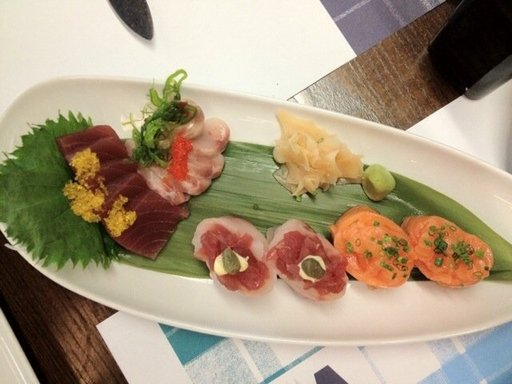

In [8]:
import random
from PIL import Image

# Set seed
random.seed(42)

# 1. Get all image paths (* means "any combination")
image_path_list = list(image_path.glob("*/*/*.jpg"))

# 2. Get random image path
random_image_path = random.choice(image_path_list)

# 3. Get image class from path name (the image class is the name of the directory where the image is stored)
image_class = random_image_path.parent.stem

# 4. Open image
img = Image.open(random_image_path)

# 5. Print metadata
print(f"Random image path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image height: {img.height}")
print(f"Image width: {img.width}")
img

We can do the same with `matplotlib.pyplot.imshow()`, except we have to convert the image to a NumPy array first.

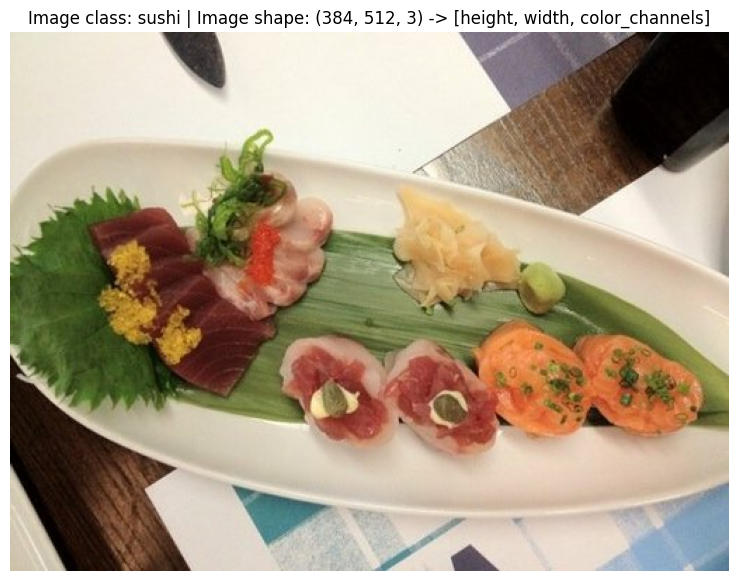

In [9]:
import numpy as np
import matplotlib.pyplot as plt

# Turn the image into an array
img_as_array = np.asarray(img)

# Plot the image with matplotlib
plt.figure(figsize=(10, 7))
plt.imshow(img_as_array)
plt.title(f"Image class: {image_class} | Image shape: {img_as_array.shape} -> [height, width, color_channels]")
plt.axis(False);